# Project 4 - Advance Lane Finding 

In this project, my goal is to write a software pipeline to identify the lane boundaries in a video and to create a detailed writeup report that discusses the methodology used in achieve the project's coding goal.

## The Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Step 0 - Import required libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
%matplotlib inline


### Step 1 - Compute Camera Parameters

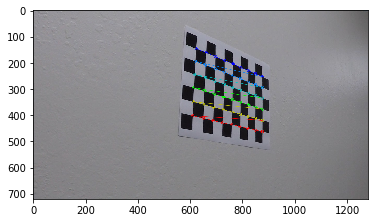

In [2]:
#Constants - Number of corners in x & y directions 
nx = 9
ny = 6

#Read in all filenames of the calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Create Arrays to store object points and images points from all the image
objpoints = []
imgpoints = []

#Prepare object points 
objp=np.zeros((nx*ny,3),np.float32)
objp[:,:2] =np.mgrid[0:nx,0:ny].T.reshape(-1,2) 

for fname in images:
    #Read in a calibration image
    img =mpimg.imread(fname)
    
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

if (imgpoints != None):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
else:
    print("Check calibration images - did not find any usuable images")

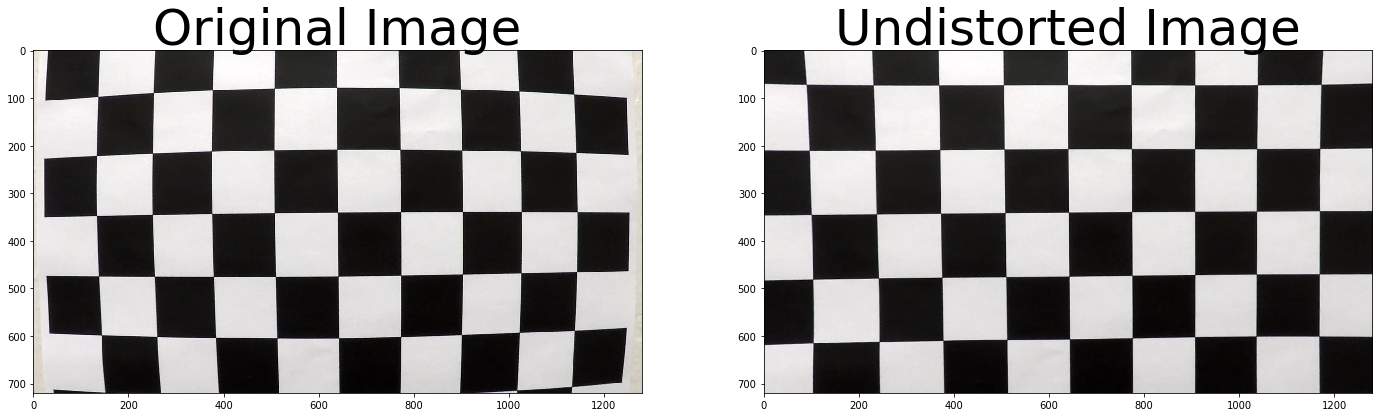

In [3]:
# Test Calibration Matrix.

#Load Test image
Test_image= mpimg.imread(images[0])
# Undistort Test Image
Test_dst = cv2.undistort(Test_image, mtx, dist, None, mtx)

#Output images for visual verification
plt.figure(figsize = (24 ,9))
plt.subplot(1,2,1)
plt.imshow(Test_image)
plt.title('Original Image',fontsize=50)


plt.subplot(1,2,2)
plt.imshow(Test_dst)
plt.title('Undistorted Image',fontsize=50)

### Step 2: Appy Image Transformation to Raw images

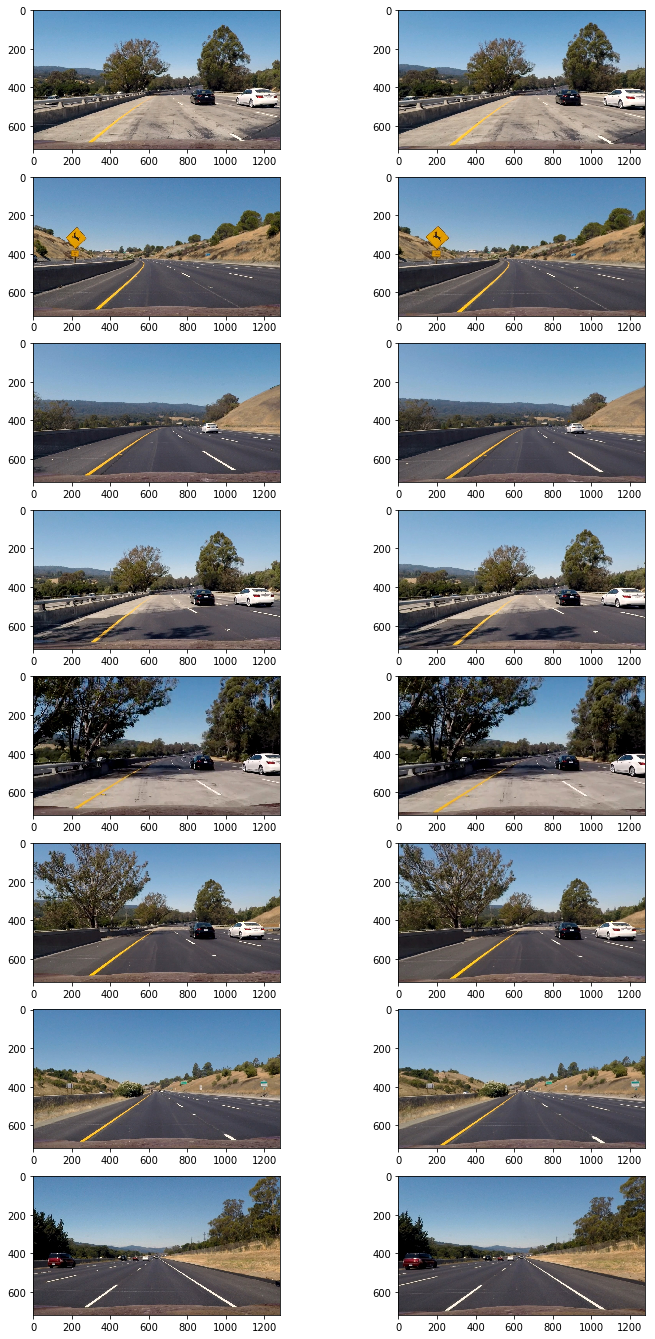

In [4]:
from PIL import Image

#Load Test Images
test_images = glob.glob("test_images/test*.jpg")

test_src =np.zeros((len(test_images),720,1280,3),dtype=np.uint8)
test_dst =np.zeros((len(test_images),720,1280,3),dtype=np.uint8)


plt.figure(figsize=(12,24))
for x in range(len(test_images)):
    #Load Test 
    test_src[x,:,:,:] =  mpimg.imread(test_images[x])
            
    #Apply Image transformation
    test_dst[x,:,:,:] = cv2.undistort(test_src[x], mtx, dist, None, mtx)
    plt.subplot(len(test_images),2,(((x+1)*2)-1))
    plt.imshow(test_src[x])
    plt.subplot(len(test_images),2,(x+1)*2)
    plt.imshow(test_dst[x])
    
mpimg.imsave("./output_images/camera_org.jpg",test_src[1])
mpimg.imsave("./output_images/camera_und.jpg",test_dst[1])

### Step 3 - Apply Color Transforms, Gradients, thresholding etc

### Define Functions for Required Transforms

In [19]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
        
    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelxy = np.sqrt(np.square(sobelx)+ np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    arctan_sobel=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(arctan_sobel)
    dir_binary[(arctan_sobel >= thresh[0]) & (arctan_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    HLS_img= cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S_img = HLS_img[:,:,2]
    L_img = HLS_img[:,:,1]
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S_img)
    #
    binary_output[((S_img > thresh[0]) & (S_img <= thresh[1]))|((L_img >200) & (L_img <= thresh[1]))] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output

def combined_type_1(img,S_thres):
    s_binary= hls_select(img,thresh=(S_thres, 255))
    grad_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=7, thresh=(100,255))
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (grad_binary == 1)] = 1
    return combined_binary

def combined_type_2(img):
    ksize = 3

    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.5, 1.57))

    combined_2 = np.zeros_like(dir_binary)
    combined_2[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_2

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

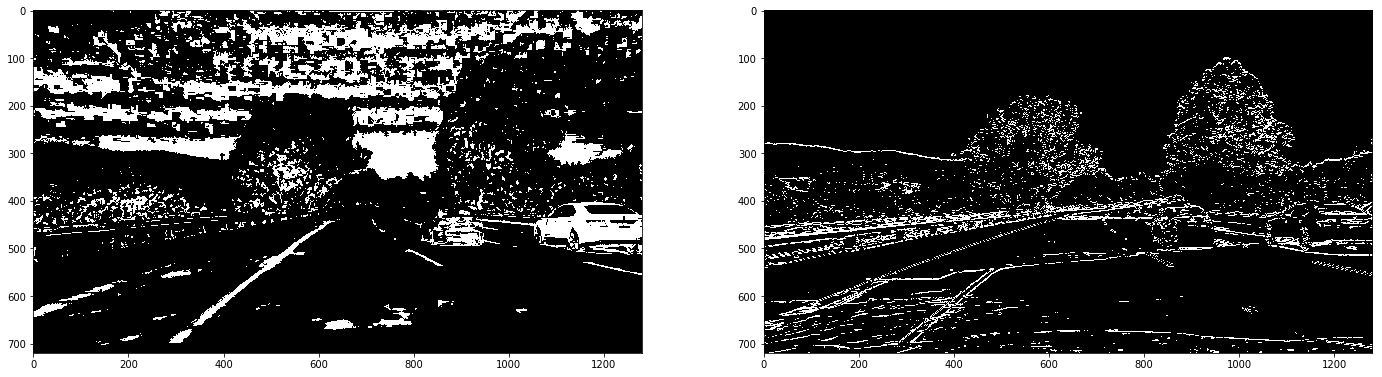

In [20]:
test_thres_1 = combined_type_1(test_dst[3],120)
test_thres_2 = combined_type_2(test_dst[3])

plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.imshow(test_thres_1,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_thres_2,cmap='gray')

### Run Combined Type 1 on all the test images

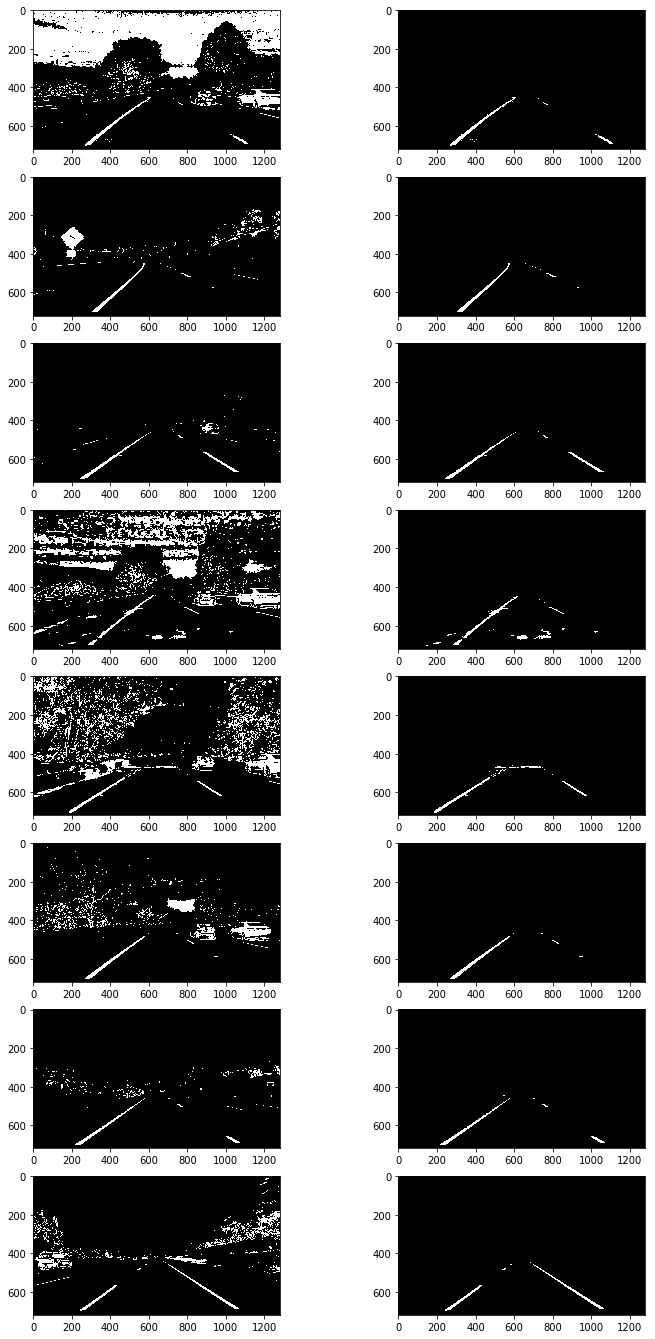

In [22]:
test_CT =np.zeros((len(test_images),720,1280),dtype=np.uint8)
test_CT_m =np.zeros((len(test_images),720,1280),dtype=np.uint8)

imshape = Test_image.shape

y_mask = 445 #int(imshape[0]*0.60)
x_mask_min = 550 #int(imshape[1]*0.45)
x_mask_max = 700 #int(imshape[1]*0.57)
#x_mask_edge = int(imshape[1]*0.04)
#print(y_mask,x_mask_min,x_mask_max,x_mask_edge)
vertices = np.array([[(100,imshape[0]),(x_mask_min, y_mask), (x_mask_max, y_mask), (imshape[1],imshape[0])]], dtype=np.int32)

plt.figure(figsize=(12,24))
for x in range(len(test_images)):
        
    #Apply Image transformation
    test_CT[x,:,:] = combined_type_1(test_dst[x],120)
    test_CT_m[x,:,:] = region_of_interest(test_CT[x,:,:],vertices)
    plt.subplot(len(test_images),2,(2*x)+1)
    plt.imshow(test_CT[x], cmap='gray')
    plt.subplot(len(test_images),2,(2*x)+2)
    plt.imshow(test_CT_m[x], cmap='gray')

mpimg.imsave("./output_images/S_Gray_thres.jpg",test_CT[1])
mpimg.imsave("./output_images/S_Gray_thres_mask.jpg",test_CT_m[1])       
    

##  Apply Transformation to Birds's Eye View 

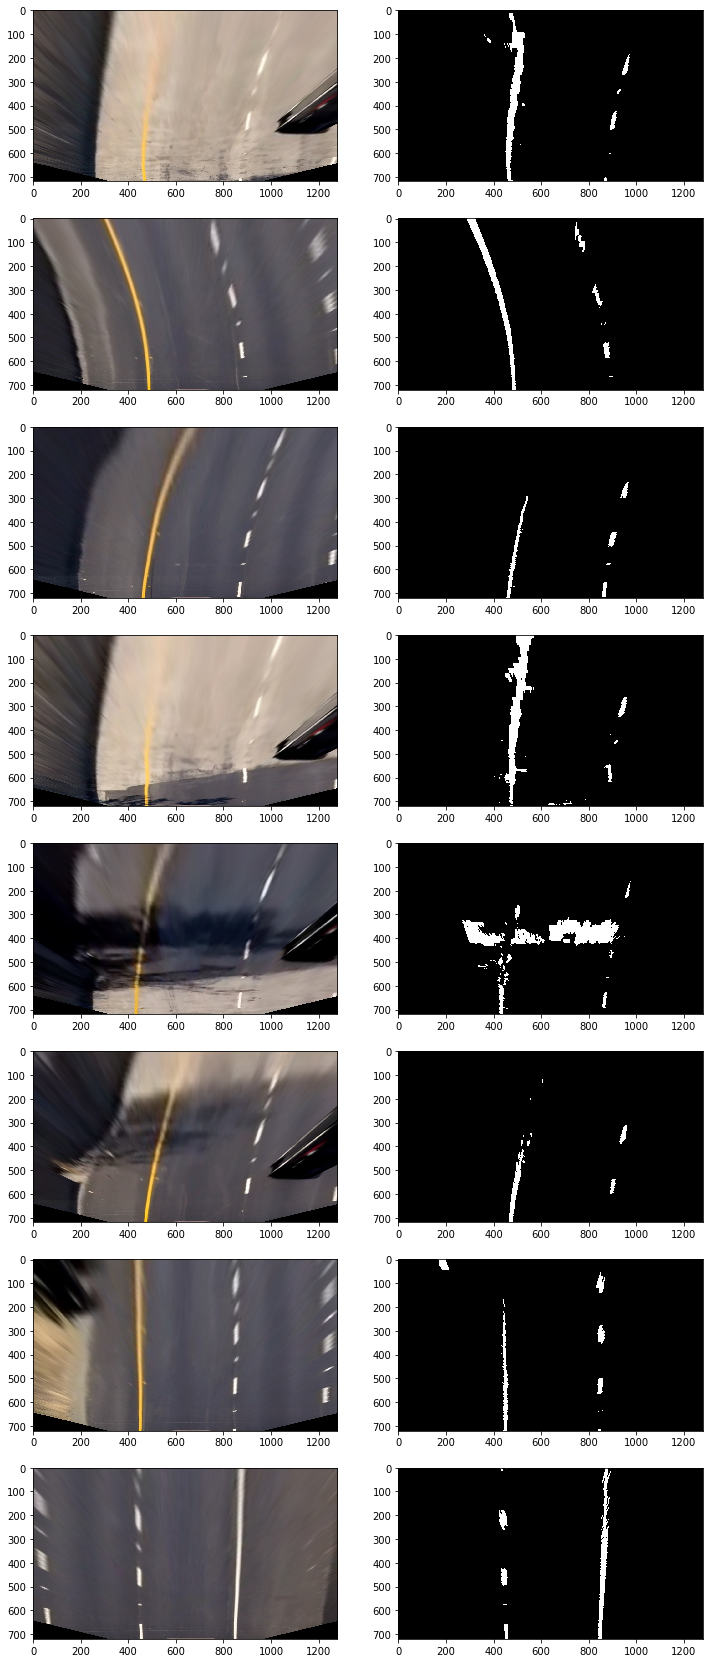

In [25]:
warped=np.zeros((len(test_images),720,1280),dtype=np.uint8)
warped_test=np.zeros((len(test_images),720,1280,3),dtype=np.uint8)

src = np.float32([[602, 447], [679, 447], [255, 687], [1060, 686]])
dst = np.float32([[450, 0], [850, 0],  [450, 720], [850, 720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(12,30))
for x in range(len(test_images)):
    warped_test[x,:,:,:] = cv2.warpPerspective(test_dst[x], M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    warped[x,:,:] = cv2.warpPerspective(test_CT_m[x], M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
    plt.subplot(len(test_images),2,(2*x)+1)
    plt.imshow(warped_test[x])
    
    plt.subplot(len(test_images),2,(2*x)+2)
    plt.imshow(warped[x], cmap="gray")

mpimg.imsave("./output_images/B_eye_org.jpg", warped_test[1])
mpimg.imsave("./output_images/B_eye_bin.jpg", warped[1])

# Step 4: Find Lanes

Radis of Curvature:  1806.81459714 m ; Center of the lane:  -0.365888888889 m
Radis of Curvature:  352.733246577 m ; Center of the lane:  -0.279555555556 m
Radis of Curvature:  581.021087418 m ; Center of the lane:  -0.222 m
Radis of Curvature:  534.04209078 m ; Center of the lane:  -0.333 m
Radis of Curvature:  617.358946216 m ; Center of the lane:  -0.0698888888889 m
Radis of Curvature:  572.830576728 m ; Center of the lane:  -0.555 m
Radis of Curvature:  5470.79749696 m ; Center of the lane:  -0.037 m
Radis of Curvature:  4158.51006653 m ; Center of the lane:  -0.0904444444444 m


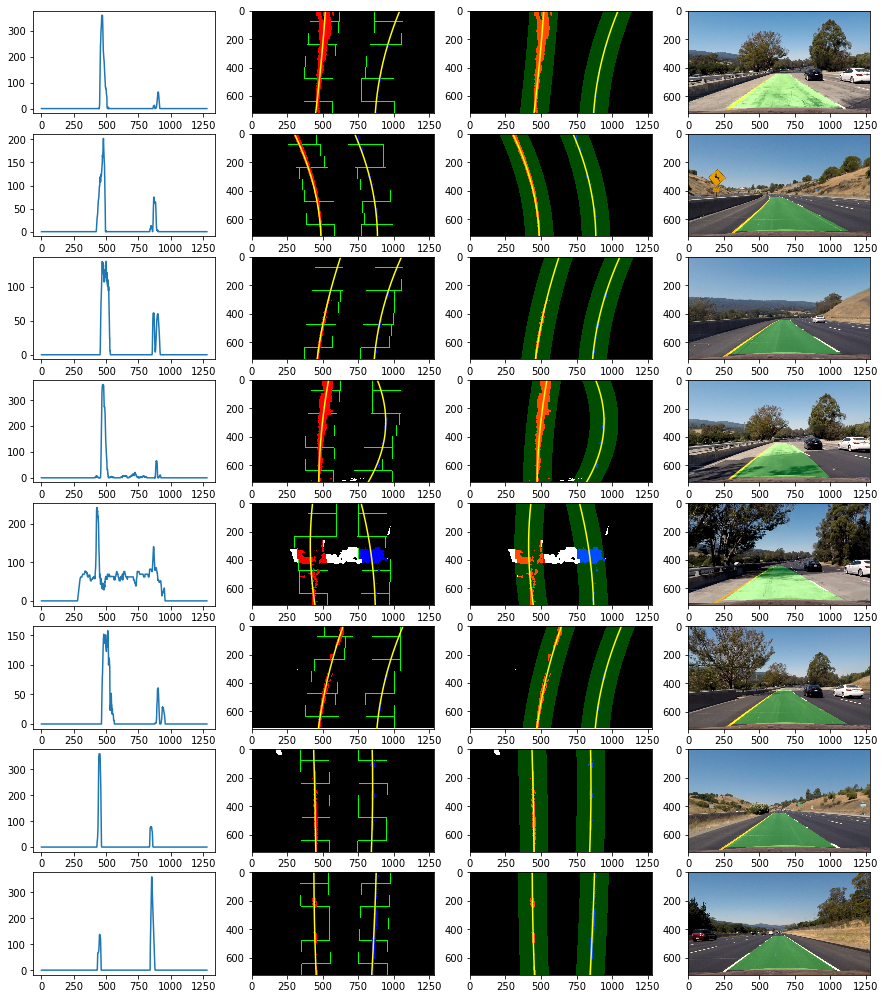

In [9]:
import os
# Constants for Lane searching.
       
nwindows = 9 # The number of sliding windows. Fine tune over [7,8,9,10,11]
window_height = np.int(warped[x].shape[0]/nwindows)
margin = 100  # Set the width of the windows +/- margin
minpix = 50 # Set minimum number of pixels found to recenter window

plt.figure(figsize =(15,20))
# Since test images are not in sync, we will run the search windows for all the test images
for x in range(len(test_images)):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[x,360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    plt.subplot(9,4,(4*x)+1)
    plt.plot(histogram)
    
    out_img = np.dstack((warped[x], warped[x], warped[x]))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped[x].nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped[x].shape[0] - (window+1)*window_height
        win_y_high = warped[x].shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped[x].shape[0]-1, warped[x].shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.subplot(9,4,(4*x)+2)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Create an image to draw on and an image to show the selection window
    out_img2 = np.dstack((warped[x], warped[x], warped[x]))*255
    window_img2 = np.zeros_like(out_img2)
    # Color in left and right line pixels
    out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    plt.subplot(9,4,(4*x)+3)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img2, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img2, np.int_([right_line_pts]), (0,255, 0))
    result1 = cv2.addWeighted(out_img2, 1, window_img2, 0.3, 0)
    plt.imshow(result1)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped[x]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    plt.subplot(9,4,(4*x)+4)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_dst[6].shape[1], test_dst[6].shape[0])) 
    # Combine the result with the original image
    result2 = cv2.addWeighted(test_dst[x], 1, newwarp, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/450 # meters per pixel in x dimension lane width/pixels
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in 
    centerCar = ((test_dst[6].shape[1]/2) - ((leftx_base+rightx_base)/2))* xm_per_pix
    RadCurv_avg = (left_curverad+right_curverad)/2
    print("Radis of Curvature: ", RadCurv_avg, 'm', "; Center of the lane: ", centerCar, 'm')
    
    output = os.path.join("output_images/",("test"+ str(x+1) +".jpg"))
    mpimg.imsave(output,result2)
    plt.imshow(result2)


In [10]:
# Test code for all ready found lines.
#binary_warped = warped[6]
#nonzero = binary_warped.nonzero()
#nonzeroy = np.array(nonzero[0])
#nonzerox = np.array(nonzero[1])
#margin = 100
#left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
#right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
#leftx = nonzerox[left_lane_inds]
#lefty = nonzeroy[left_lane_inds] 
#rightx = nonzerox[right_lane_inds]
#righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
#left_fit = np.polyfit(lefty, leftx, 2)
#right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
#ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [11]:
from collections import deque

# Define Class to store and compare avlues
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
                        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        self.diffcoeff_0 = []
        self.diffcoeff_1 = []
        self.diffcoeff_2 = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = []
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
                  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_0 = deque(maxlen=20)
        self.best_fit_1 = deque(maxlen=20)
        self.best_fit_2 = deque(maxlen=20)
    

font = cv2.FONT_HERSHEY_SIMPLEX
    
def pipeline(image, L_Line, R_Line,S_thres,M,Minv):
    imshape = image.shape
    nwindows = 9 # 
    window_height = np.int(imshape[0]/nwindows)
    margin = 100  # Set the width of the windows +/- margin
    minpix = 50 #
        
    #Apply Image transformation - Undistort - Intrinstic parameters
    image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    #Apply Colour/Space filters
    test_CT = combined_type_1(image_undist,S_thres)
    test_CT_m = region_of_interest(test_CT,vertices)
    
    #Get Bird's Eye View Transformation
    warped = cv2.warpPerspective(test_CT_m, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
     # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    if (L_Line.detected == False)|(R_Line.detected == False):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(warped[360:,:], axis=0)
        out_img = np.dstack((warped, warped, warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
             
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = imshape[0] - (window+1)*window_height
            win_y_high = imshape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
           
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
              
    else:
        #Lane Detected previously, so utilize the line fit from the previous images
               
        left_lane_inds = ((nonzerox > (L_Line.current_fit[0]*(nonzeroy**2)+ L_Line.current_fit[1]*nonzeroy + L_Line.current_fit[2] - margin)) & 
                          (nonzerox < (L_Line.current_fit[0]*(nonzeroy**2)+ L_Line.current_fit[1]*nonzeroy + L_Line.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox> (R_Line.current_fit[0]*(nonzeroy**2)+ R_Line.current_fit[1]*nonzeroy + R_Line.current_fit[2] - margin)) & 
                          (nonzerox < (R_Line.current_fit[0]*(nonzeroy**2)+ R_Line.current_fit[1]*nonzeroy + R_Line.current_fit[2] + margin)))  
    
   
    try :
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        coeff2 = -1
        if (len(L_Line.best_fit_0) > 1):
            L_Line.diffcoeff_0.append(abs(L_Line.best_fit_0[-1] - left_fit[0]))
            L_Line.diffcoeff_1.append(abs(L_Line.best_fit_1[-1] - left_fit[1]))
            L_Line.diffcoeff_2.append(abs(L_Line.best_fit_2[-1] - left_fit[2]))
            coeff2 = abs(L_Line.best_fit_2[-1] - left_fit[2])
        
        if (coeff2 < 200):
            L_Line.best_fit_0.append(left_fit[0]) 
            L_Line.best_fit_1.append(left_fit[1])
            L_Line.best_fit_2.append(left_fit[2])

            R_Line.best_fit_0.append(right_fit[0]) 
            R_Line.best_fit_1.append(right_fit[1])
            R_Line.best_fit_2.append(right_fit[2])

            L_Line.allx = leftx
            L_Line.ally = lefty

            R_Line.allx = rightx
            R_Line.ally = righty

            L_Line.detected = True
            R_Line.detected = True
        else:
            L_Line.detected = False
            R_Line.detected = False
            
        left_fit[0]=np.mean(L_Line.best_fit_0)
        left_fit[1]=np.mean(L_Line.best_fit_1)
        left_fit[2]=np.mean(L_Line.best_fit_2)
          
        right_fit[0]=np.mean(R_Line.best_fit_0)
        right_fit[1]=np.mean(R_Line.best_fit_1)
        right_fit[2]=np.mean(R_Line.best_fit_2)
    
        L_Line.current_fit = left_fit
        R_Line.current_fit = right_fit
        
    except :
        
        left_fit = np.polyfit(L_Line.allx, L_Line.ally, 2)
        right_fit = np.polyfit(R_Line.allx, R_Line.ally, 2)
        
        L_Line.detected = False
        R_Line.detected = False
               
      
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (imshape[1], imshape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/450 # meters per pixel in x dimension lane width/pixels
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in 
    centerCar = ((imshape[1]/2) - ((left_fitx[-1]+right_fitx[-1])/2))* xm_per_pix
    RadCurv_avg = (left_curverad+right_curverad)/2
    L_Line.radius_of_curvature.append(left_curverad)
    R_Line.radius_of_curvature.append(right_curverad)
        
    cv2.putText(result,'Car Center: '+ str(centerCar)+'m',(10,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Road Radius of Curvature: '+ str(round(RadCurv_avg,2))+'m',(10,120), font, 1,(255,255,255),2,cv2.LINE_AA)

    return result
    

In [12]:
L_Line  = Line()
R_Line  = Line()
S_thres = 120
src = np.float32([[602, 447], [679, 447], [255, 687], [1060, 686]])
dst = np.float32([[450, 0], [850, 0],  [450, 720], [850, 720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

Result = pipeline(test_dst[0], L_Line, R_Line, S_thres, M, Minv)



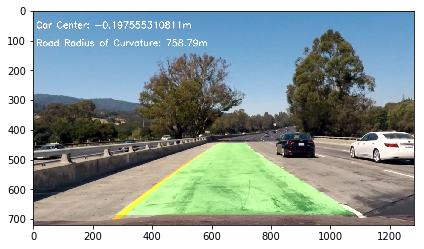

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Result)


In [14]:
def process_pipeline(image):
    S_thres = 100
    src = np.float32([[602, 447], [679, 447], [255, 687], [1060, 686]])
    dst = np.float32([[450, 0], [850, 0],  [450, 720], [850, 720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    Result = pipeline(image, L_Line, R_Line,S_thres,M,Minv)
    return Result
    

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'Output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

L_Line  = Line()
R_Line  = Line()

white_clip = clip1.fl_image(process_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Output_project_video.mp4
[MoviePy] Writing video Output_project_video.mp4


100%|████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:11<00:00,  9.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_project_video.mp4 

Wall time: 2min 11s


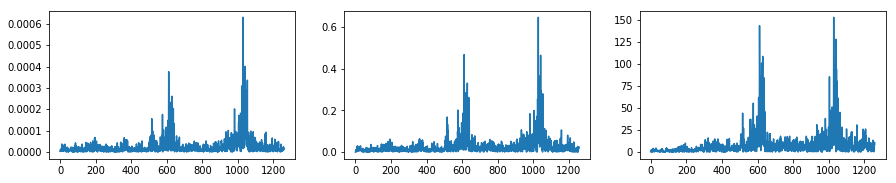

In [16]:
plt.figure(figsize=(15,6))
plt.subplot(2,3,1)
plt.plot(L_Line.diffcoeff_0)
plt.subplot(2,3,2)
plt.plot(L_Line.diffcoeff_1)
plt.subplot(2,3,3)
plt.plot(L_Line.diffcoeff_2)

plt.figure(figsize=(15,6))



In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))